# 7 Leaf and canopy radiative transfer modeling

## Aim
So far, all our analyses were based on statistical models. These models are able to accurately describe observed
relationships between spectral data and thematic information. They do not, however, take into account the physical
principles behind these relationships. The radiative transfer models PROSPECT (Jacquemoud & Baret 1990) and
4SAIL (Verhoef 1984) and other members of the PROSPECT/SAIL model family address this issue and model the
path of light through a leaf and a vegetation canopy, respectively. In this training, we explore the coupled
PROSPECT and SAIL models (= PROSAIL) and use a statistical inversion of the model to map Leaf Mass per Area
(LMA [g*cm 2 ]), a functional plant trait, in a wetland under water stress

## PROSAIL

### Q7.1: 
What are the default values for N, CHL, CAR, EWT, LMA, LAI and leaf angle distribution?

**Answer:** The default values from Pro4Sail in R are:
```
PRO4SAIL <- function(Spec_Sensor = NULL, Input_PROSPECT = NULL, N = 1.5,
                     CHL = 40.0, CAR = 8.0, ANT = 0.0, BROWN = 0.0, EWT = 0.01,
                     LMA = NULL, PROT = 0.0, CBC = 0.0, alpha = 40.0,
                     TypeLidf = 2, LIDFa = 60, LIDFb = NULL, lai = 3,
                     q = 0.1, tts = 30, tto = 0, psi = 60, rsoil = NULL,
                     fraction_brown = 0.0, diss = 0.0, Cv = 1, Zeta = 1,
                     SAILversion = '4SAIL', BrownLOP = NULL)
```              
```
N (Leaf structure parameter = # mesophyll layers): 1.5
CHL (Chlorophyll a & b concentration µg/cm²): 40
CAR (Carotenoid content in µg/cm²): 8
EWT (Equivalent water thickness in cm): 0.01
LMA (Leaf dry mass per area g/cm²): NULL (no fixed numeric default)
LAI (Leaf area index): 3
Leaf Angle Distribution: ellipsoidal distribution (TypeLidf = 2) with LIDFa = 60
```

If TypeLidf is 2:

A single number defines the average leaf angle (in degrees) for an elipsoidal distribution.
0 is planophile and 90 is erectophile.


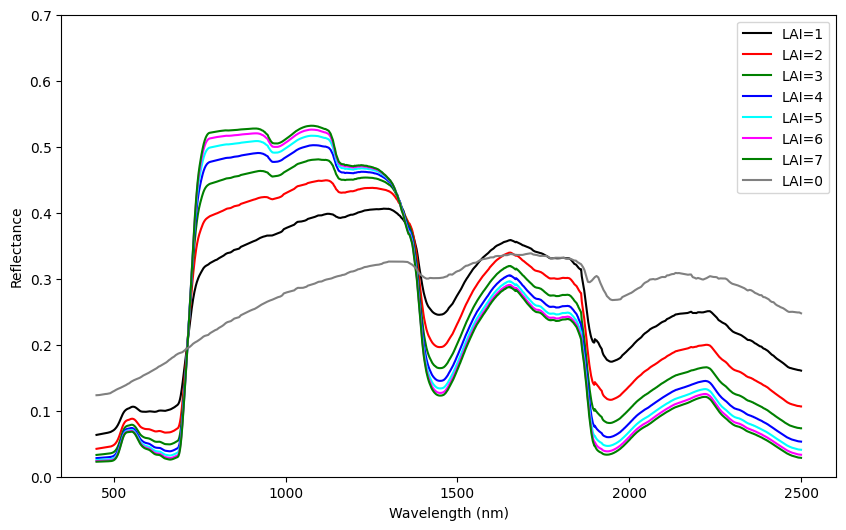

In [54]:
import os

# in Python > 3.8 with Windows, dll's are only loaded from trusted locations https://docs.python.org/3/whatsnew/3.8.html#ctypes
# Add the DLL directory to the search path
dll_path = r"C:\Users\louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\_prosail_model\.libs"
os.add_dll_directory(dll_path)

import numpy as np
import matplotlib.pyplot as plt
import pyprosail # this needs C++ and Fortran compiler

#   * ``n`` -- Structure co-efficient
#   * ``cab`` -- Chlorophyll content (ug per cm^2)
#   * ``car`` -- Carotenoid content (ug per cm^2)
#   * ``cbrown`` -- Brown pigment content (arbitrary units)
#   * ``cw`` -- Equivalent Water Thickness (cm)
#   * ``cm`` -- Leaf Mass per unit area (g per cm^2)
#   * ``psoil`` -- Soil reflectance: wet soil = 0, dry soil = 1
#   * ``lai`` -- Leaf Area Index
#   * ``hot_spot`` -- Hot spot parameter
#   * ``tts`` -- Solar zenith angle (degrees)
#   * ``tto`` -- Observer zenith angle (degrees)
#   * ``psi`` -- relative azimuth angle (degrees)
#   * ``typelidf`` -- Type of leaf angle distribution to use
#   * ``lidfa`` -- Leaf distribution function parameter a (see below)
#   * ``lidfb`` -- Leaf distribution function parameter b (see below)
params = {
    'n': 1.5,
    'cab': 40,
    'car': 8,
    'cbrown': 0,
    'cw': 0.01,
    'cm': 0.01,
    'psoil': 0.5,
    'hspot': 0.01,
    'tts': 0,
    'tto': 0,
    'psi': 0,
    'typelidf': 2,
    'lidfa': 60,
    'lidfb': 0
}

lai_values = [1, 2, 3, 4, 5, 6, 7, 0]
colors = ['black', 'red', 'green', 'blue', 'cyan', 'magenta', 'green', 'gray']

plt.figure(figsize=(10, 6))
plt.ylim(0, 0.7)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")

for lai, color in zip(lai_values, colors):
    result = pyprosail.run(lai=lai, **params)
    
    subset = result[50:]
    wavelengths = subset[:, 0]
    reflectance = subset[:, 1]
    
    plt.plot(wavelengths, reflectance, color=color, label=f'LAI={lai}')

plt.legend()
plt.show()

### Q7.2: 
Which parts of the spectrum are changing and which remain stable? Is the relationship between LAI
and canopy reflectance strictly linear?

**Answer:** No parts of the spectrum seem to remain completely stable. From 450 - 700 nm and 1300 - 2500 nm the reflectance seems to be inversely related to the LAI; from 700-1300 positively correlated to it. Although the relationship is not strictly linear. If so we would see the same increase/decrease from LAI 2 to 4 and 4 to 6. It seems to saturate as the LAI increases, resembling some logistic behavior.

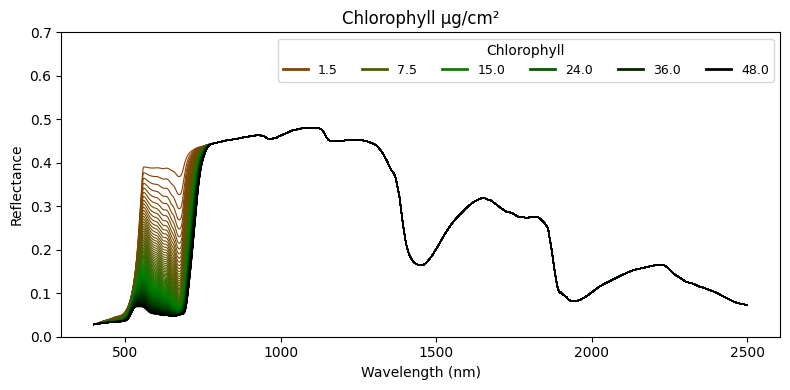

In [55]:
from matplotlib.colors import LinearSegmentedColormap

# chlorophyll concentrations
chl_values = np.arange(0.3, 48 + 0.3, 0.3)
num_spectra = len(chl_values)

spectra = np.zeros((num_spectra, 2101))

# Generate spectra
for i, cab in enumerate(chl_values):
    params['cab'] = cab
    result = pyprosail.run(lai= 3, **params)
    spectra[i] = result[:, 1] 

colors = [(0.55, 0.25, 0.0), (0, 0.5, 0), (0, 0.2, 0), (0, 0, 0)]
cmap = LinearSegmentedColormap.from_list('chl_gradient', colors, N=160)

# Plot setup
plt.figure(figsize=(8, 4))
plt.title('Chlorophyll μg/cm²')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.ylim(0, 0.7)

for i in range(num_spectra):
    plt.plot(result[:, 0], spectra[i], color=cmap(i), lw=0.8)

legend_values = [1.5, 7.5, 15, 24, 36, 48]
legend_indices = [int((v - 0.3)/0.3) for v in legend_values]
legend_colors = [cmap(i) for i in legend_indices]

legend_lines = [plt.Line2D([0], [0], color=c, lw=2) for c in legend_colors]
plt.legend(legend_lines, [f'{v:.1f}' for v in legend_values], 
           title='Chlorophyll', loc='upper right', ncol=6, fontsize=9)

plt.tight_layout()
plt.show()

### Q7.3: 
Explain in 2 3 sentences the influence of chlorophyll on canopy reflectance.

**Answer:** 
Chlorophyll significantly influences canopy reflectance in the visible range of the spectrum (400-700), less in the lower NIR (700-800) and not at all above that wavelengths. In the visible range, chlorophyll strongly absorbs light, leading to low reflectance for higher clorophyll values, highest reflectance for the lowest (1.5) values.

## Building a lookup table

In [ ]:
from math import prod
from itertools import product

# R seq is [start, stop], np.arange is [start, stop)
param_ranges = {
    'N': np.arange(1.1, 2.3 + 0.15, 0.15).round(2),
    'CHL': np.arange(1, 46 + 3, 3),
    'CAR': np.arange(1, 25 + 2, 2),
    'BROWN': np.arange(0, 1 + 1, 1),
    'EWT': np.arange(0.002, 0.024 + 0.002, 0.002),
    'LAI': np.arange(0.5, 7 + 0.5, 0.5)
}

param_names = list(param_ranges.keys())
param_combinations = product(*[param_ranges[k] for k in param_names])

lengths = [len(v) for v in param_ranges.values()]
print(lengths)
print(prod(lengths))

[9, 16, 13, 2, 12, 14]
628992


### Q7.4: 
How many combinations of the six parameters (not including LMA) are possible for the given ranges
and intervals?

**Answer:** 
There are 628992 combinations possible.

In [57]:
import pandas as pd
from tqdm import tqdm

param_df = pd.DataFrame(param_combinations, columns=param_names)

sampled_df = param_df.sample(n=20000, random_state=42, ignore_index=True)

sampled_df['LMA'] = np.linspace(0.002, 0.018, num=20000)

# randomize row order
shuffled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

spectra = np.zeros((20000, 2101))

fixed_params = {
    'psoil': 0.5,
    'hspot': 0.01,
    'tts': 0,
    'tto': 0,
    'psi': 0,
    'typelidf': 2,
    'lidfa': 60,
    'lidfb': 0
}

for i in tqdm(range(len(shuffled_df)), desc="Generating Spectra"):
    row = shuffled_df.iloc[i]
    result = pyprosail.run(
        n=row['N'],
        cab=row['CHL'],
        car=row['CAR'],
        cbrown=row['BROWN'],
        cw=row['EWT'],
        lai=row['LAI'],
        cm=row['LMA'],
        **fixed_params
    )
    spectra[i] = result[:, 1]

lookup_table = pd.concat([
    shuffled_df,
    pd.DataFrame(spectra, columns=[f'band_{i}' for i in range(2101)])
], axis=1)

Generating Spectra: 100%|██████████| 20000/20000 [00:29<00:00, 668.36it/s]


## Image data

(115, 1079, 1013)


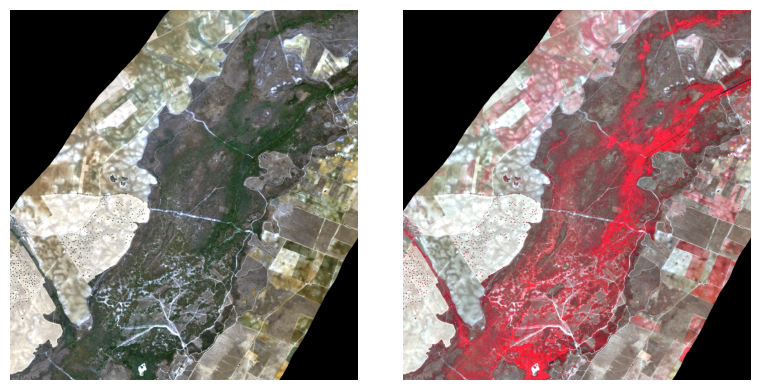

In [58]:
import rasterio

data_path = "C:/Users/louis/Desktop\Hyperspectral Remote Sensing/Sheet07/data"

image_path = f"{data_path}/090812_level1FGMosNorth.img"

image = rasterio.open(image_path)
image_data = image.read()
transform = image.transform

print(image_data.shape)

def coord_to_pixel(x, y, transform):
    col, row = ~transform * (x, y)
    return int(col), int(row)

# this replaces the stretch='lin'
def linear_stretch(band, lower_percent=2, upper_percent=98):
    
    lower = np.percentile(band, lower_percent)
    upper = np.percentile(band, upper_percent)    
    # Clip and scale
    stretched_band = np.clip(band, lower, upper)
    stretched_band = (stretched_band - lower) / (upper - lower)
    return stretched_band

band25 = linear_stretch(image_data[25])     
band13 = linear_stretch(image_data[13]) 
band8 = linear_stretch(image_data[8]) 
band2 = linear_stretch(image_data[2])  

rgb = np.dstack((band13, band8, band2))
nir_rg = np.dstack((band25, band13, band8))

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nir_rg)
plt.axis('off')
plt.tight_layout()
plt.show()

### Q7.5: 
Why is an accurate atmospheric correction of the image data inevitable if they are analyzed with the
PROSAIL model?

**Answer:**
PROSAIL simulates surface-level canopy reflectance, which represents the reflectance before interacting with the atmosphere. Airborne sensors like HyMap measure top-of-atmosphere reflectance (after interacting with the atmosphere); distorted by effects like scattering and absorption (e.g. O2).

So the generated spectra (surface reflectance) will not align with the observed reflectance and the lookuptable will mismatch.

## Resampling the spectral library

In [59]:
from joblib import Parallel, delayed
from tqdm import tqdm

hymap_wl = np.array([
    0.455400, 0.469400, 0.484300, 0.499100, 0.513800, 0.528800,
    0.543600, 0.558400, 0.573100, 0.588100, 0.602900, 0.617600,
    0.632000, 0.646500, 0.660900, 0.675500, 0.690000, 0.704500,
    0.718900, 0.733200, 0.747600, 0.761800, 0.775900, 0.790100,
    0.804600, 0.818800, 0.832900, 0.847100, 0.861100, 0.874700,
    0.887800, 0.893000, 0.908500, 0.923900, 0.939400, 0.955200,
    0.970400, 0.985800, 1.001400, 1.016600, 1.031800, 1.046900,
    1.062000, 1.076600, 1.091300, 1.106200, 1.120800, 1.135300,
    1.149700, 1.164100, 1.178600, 1.192800, 1.206900, 1.221000,
    1.235100, 1.249200, 1.263100, 1.277000, 1.290700, 1.304300,
    1.318300, 1.330100, 1.462600, 1.477100, 1.491100, 1.505000,
    1.518800, 1.532600, 1.546300, 1.559800, 1.573200, 1.586400,
    1.599500, 1.612700, 1.625900, 1.638900, 1.651700, 1.664400,
    1.677100, 1.689600, 1.702100, 1.714600, 1.726900, 1.739300,
    1.751500, 1.763600, 1.775600, 1.787600, 1.798100, 2.008300,
    2.027500, 2.046700, 2.065500, 2.084100, 2.102500, 2.120900,
    2.139000, 2.157000, 2.174700, 2.191700, 2.210300, 2.228100,
    2.245600, 2.263400, 2.280400, 2.297400, 2.314400, 2.331400,
    2.348300, 2.365000, 2.381500, 2.397700, 2.414100, 2.430300,
    2.446500
]) * 1000 
original_wl = np.arange(400, 2501)

spectral_data = lookup_table[[f'band_{i}' for i in range(2101)]].values

def resamp_spectrum(spectrum):
    resampled = np.interp(hymap_wl, original_wl, spectrum)
    return resampled

# parallel processing
def parallel_resample(data, n_jobs=-2):
    return Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(resamp_spectrum)(spectrum) 
        for spectrum in tqdm(data, desc="Resampling spectra")
    )

resampled_spectra = np.array(parallel_resample(spectral_data))

hymap_bands = [f'nm{wl:.1f}' for wl in hymap_wl]
final_lut = pd.concat([
    lookup_table[['LMA', 'N', 'CHL', 'CAR', 'BROWN', 'EWT', 'LAI']],
    pd.DataFrame(resampled_spectra, columns=hymap_bands)
], axis=1)

Resampling spectra: 100%|██████████| 20000/20000 [00:03<00:00, 5191.62it/s]
[Parallel(n_jobs=-2)]: Done 20000 out of 20000 | elapsed:    3.8s finished


## Training a regression model for the statistical inversion

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = final_lut[hymap_bands]
y = final_lut['LMA']

X_cal = X.iloc[:5000]
y_cal = y.iloc[:5000]
X_val = X.iloc[5000:]
y_val = y.iloc[5000:]

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
print("Training the model")
rf.fit(X_cal, y_cal)

pred = rf.predict(X_val)


Training the model


In [61]:
# from scipy.stats import pearsonr
from sklearn.metrics import r2_score

cal_pred = rf.predict(X_cal)
r2_cal = r2_score(y_cal,cal_pred)
rmse_cal = np.sqrt(mean_squared_error(y_cal, cal_pred))

r2_val = r2_score(y_val, pred)
rmse = np.sqrt(mean_squared_error(y_val, pred))


print(f"Calibration R²: {r2_cal:.3f}")
print(f"Validation RMSE: {rmse_cal:.5f}")
print(f"Validation R²: {r2_val:.3f}")
print(f"Validation RMSE: {rmse:.5f}")

Calibration R²: 0.987
Validation RMSE: 0.00053
Validation R²: 0.904
Validation RMSE: 0.00144


### Q7.6: 
How large is the percentage of variance in the calibration data that could be explained by the random
forest model?

**Answer:** 98.7 %

### Q7.7: 
Does the explained variance (=R2 *100) in validation differ from the explained variance in calibration?

**Answer:** Yes, it is lower (98,7% vs 90,4%), because the R2 of calibration is often overoptimistic.

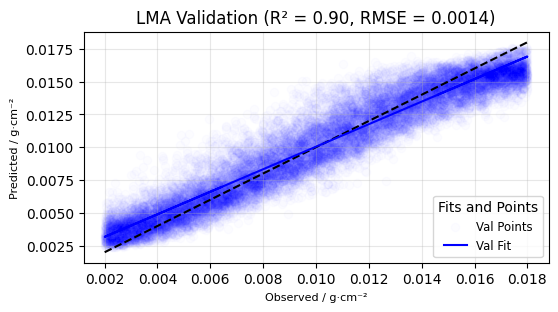

In [69]:
def regression_plot(y_pr):

    r2_validation = r2_score(y_val, y_pr)
    rmse_validation = np.sqrt(mean_squared_error(y_val, y_pr))

    plt.figure(figsize=(6, 3))

    plt.scatter(y_val, y_pr, color='#0000FF', label='Val Points', alpha=0.01)
    lims = [y_val.min(), y_val.max()]
    plt.plot(lims, lims, color='black', linestyle='--')  # f(x)=x

    val_fit = np.polyfit(y_val, y_pr, 1)
    plt.plot(y_val, np.polyval(val_fit, y_val), color='#0000FF', label='Val Fit')

    plt.legend(loc='lower right', fontsize='small', title="Fits and Points")

    plt.xlabel('Observed / g·cm⁻²', fontsize=8)
    plt.ylabel('Predicted / g·cm⁻²', fontsize=8)
    plt.title(f'LMA Validation (R² = {r2_validation:.2f}, RMSE = {rmse_validation:.4f})', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

regression_plot(pred)

### Q7.8: 
Build another retrieval model using PLSR.

100%|██████████| 28/28 [00:04<00:00,  6.08it/s]


Best number of latent vectors: 28 RMSE: 0.0011705882220306367


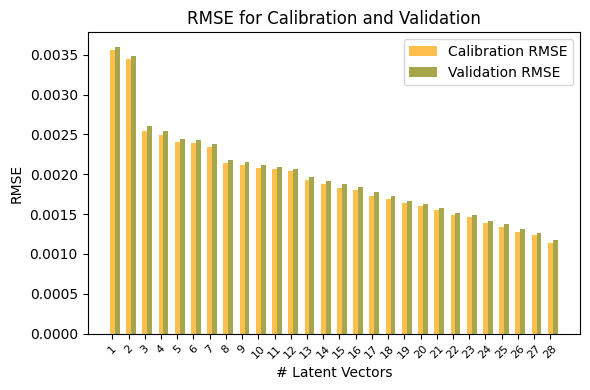

In [66]:
from sklearn.cross_decomposition import PLSRegression

def latent_vector_plot(X_calibration, y_calibration, X_validation, y_validation):
    rmse_cal = []
    rmse_val = []

    for n_comp in tqdm(range(1, 29)):
        pls = PLSRegression(n_components=n_comp, scale=True)
        pls.fit(X_calibration, y_calibration)

        y_cal_pred = pls.predict(X_calibration)
        rmse_cal.append(np.sqrt(mean_squared_error(y_calibration, y_cal_pred)))
        
        y_val_pred = pls.predict(X_validation)
        rmse_val.append(np.sqrt(mean_squared_error(y_validation, y_val_pred)))

    nlv = np.argmin(rmse_val) + 1

    print("Best number of latent vectors:", nlv, "RMSE:", rmse_val[nlv-1])
    latent_vectors = np.arange(1, len(rmse_val) + 1)

    plt.figure(figsize=(6, 4))
    width = 0.3

    plt.bar(latent_vectors, rmse_cal, width=width, color='orange', label='Calibration RMSE', alpha=0.7)
    plt.bar(latent_vectors + width, rmse_val, width=width, color='olive', label='Validation RMSE', alpha=0.7)

    plt.xlabel('# Latent Vectors')
    plt.ylabel('RMSE')
    plt.xticks(latent_vectors, fontsize=8, rotation=45)
    plt.legend(loc='upper right')
    plt.title('RMSE for Calibration and Validation')
    plt.tight_layout()
    plt.show()

    return nlv

nlv = latent_vector_plot(X_cal, y_cal, X_val, y_val)

We clearly run into issue here assessing the best number of latent vectors. One reason could be that the simulated data is too perfect; we have to add some noise. We do this just for assessing the best number of latent vectors, and then go on with the perfect data, to have a better comparison to the RF model.

In [64]:
# Different SNR for calibration and validation
def wavelength_to_snr(wl, cal):
    if 400 <= wl < 1300:
        return 600 if cal else 400
    elif 1300 <= wl < 1800:
        return 450 if cal else 300
    else:
        return 300 if cal else 200

def add_spectral_noise(spectra, wavelengths, cal):
    noisy_spectra = np.zeros_like(spectra)
    for i, spectrum in enumerate(spectra):
        noise = np.array([np.random.normal(0, 1/wavelength_to_snr(wl, cal)) for wl in wavelengths])
        noisy_spectra[i] = np.clip(spectrum + noise, 0, 1)
    return noisy_spectra

X_cal_noisy = add_spectral_noise(X_cal.values, hymap_wl, cal = True)
X_val_noisy = add_spectral_noise(X_val.values, hymap_wl, cal = False)

100%|██████████| 28/28 [00:03<00:00,  7.42it/s]


Best number of latent vectors: 11 RMSE: 0.002182722914251138


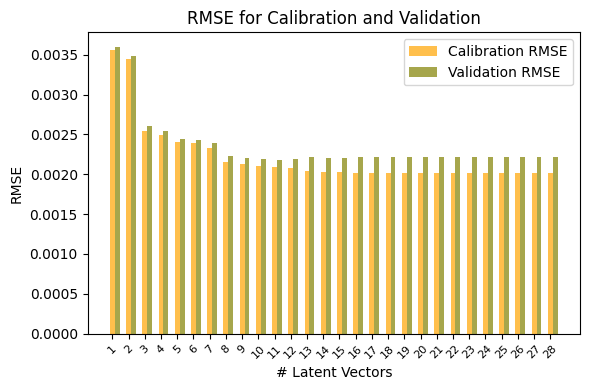

In [67]:
nlv = latent_vector_plot(X_cal_noisy, y_cal, X_val_noisy, y_val)

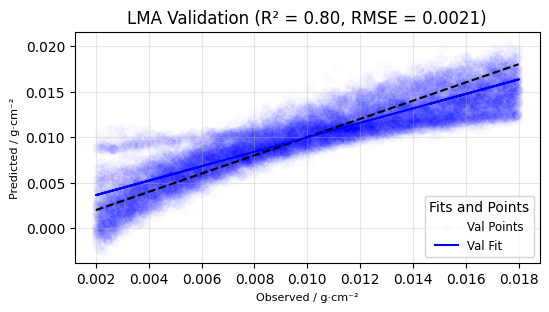

In [ ]:
pls_mod = PLSRegression(n_components=nlv, scale=True)
pls_mod.fit(X_cal, y_cal)
pls_predict = pls_mod.predict(X_val)

regression_plot(pls_predict)

The predictions on the noisy data would also be interesting:

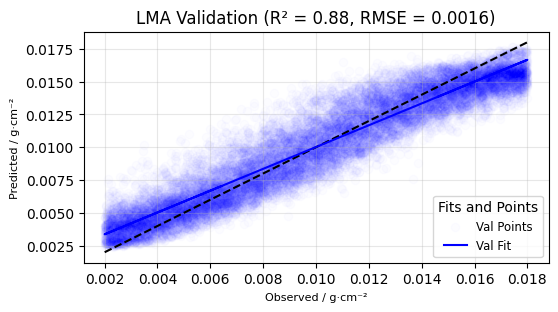

In [72]:
rf2 = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf2.fit(X_cal_noisy, y_cal)
pred2 = rf2.predict(X_val_noisy)

regression_plot(pred2)

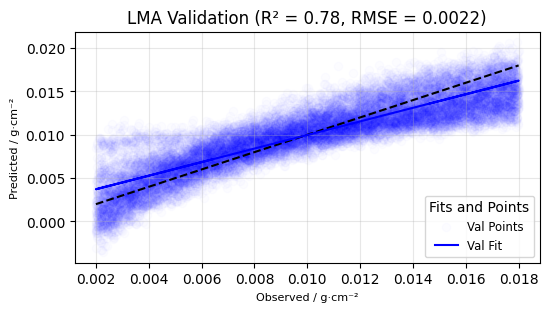

In [73]:
pls_mod2 = PLSRegression(n_components=nlv, scale=True)
pls_mod2.fit(X_cal_noisy, y_cal)
pls_predict2 = pls_mod2.predict(X_val_noisy)

regression_plot(pls_predict2)

Random Forest Top 3 Wavelengths:
1. 1091.3 nm
2. 1714.6 nm
3. 1120.8 nm

PLSR Top 3 Wavelengths:
1. 1714.6 nm
2. 2008.3 nm
3. 1726.9 nm


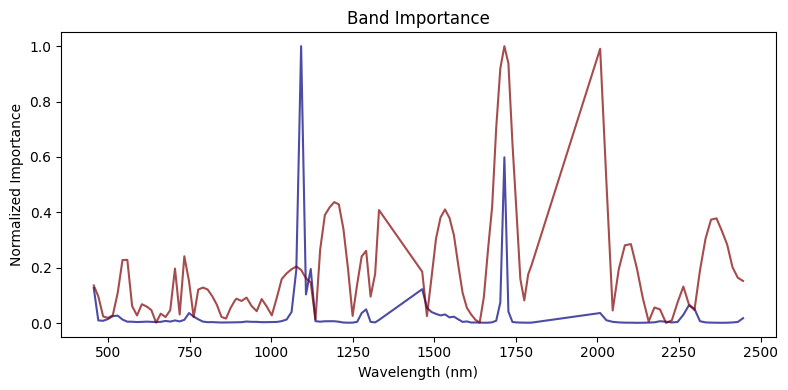

In [83]:
rf_importance = rf.feature_importances_
pls_importance = np.abs(pls_mod.coef_.flatten())

rf_norm = rf_importance / rf_importance.max()
pls_norm = pls_importance / pls_importance.max()

wavelengths = np.array([float(band.replace('nm','')) for band in hymap_bands])

rf_top3 = wavelengths[np.argsort(rf_norm)[-3:][::-1]]
pls_top3 = wavelengths[np.argsort(pls_norm)[-3:][::-1]]

print("Random Forest Top 3 Wavelengths:")
for i, wl in enumerate(rf_top3, 1):
    print(f"{i}. {wl:.1f} nm")

print("\nPLSR Top 3 Wavelengths:")    
for i, wl in enumerate(pls_top3, 1):
    print(f"{i}. {wl:.1f} nm")

plt.figure(figsize=(8, 4))
plt.plot(wavelengths, rf_norm, 'navy', label='RFR', alpha= 0.7)
plt.plot(wavelengths, pls_norm, 'maroon', label='PLSR', alpha= 0.7)
plt.title('Band Importance')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Importance')
plt.tight_layout()
plt.show()

### Q7.8: 
Describe your modeling workflow. Does the model fit differ
from the fit gained through RFR? Compare the band importance metrics of the RFR and PLSR. Do they
agree on similar spectral bands that are best suited to retrieve LMA from the spectra?

**Answer:** To better assess the number of latent vectors for the PLSR I had to add some noise to the data. Otherwise, calibration and validation RMSE kept decreasing with the number of latent vectors. PLSR is so much faster than RFR (0.5s vs 90s+), but showed worse performance on both the perfect and noisy data.

They agree on that the 1714.6 nm seems to be important for LAM retrieval, besides this they do not show much similarities.


## Mapping LMA

In [84]:
bands, height, width = image_data.shape

pixval_df = pd.DataFrame(
    image_data.astype(np.float32).reshape(bands, -1).T / 10000.0,
    columns=hymap_bands
)

mapvalues = rf.predict(pixval_df).flatten()
lma_map = mapvalues.reshape(height, width)

(-0.5, 1012.5, 1078.5, -0.5)

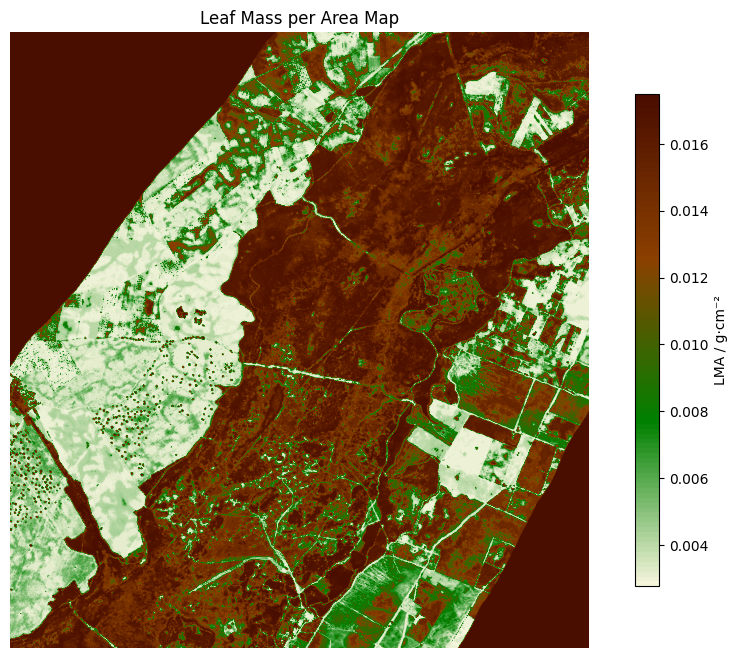

In [107]:
colors = ["beige", "#008000", "#8B4000", "#490d00"]
cmap = LinearSegmentedColormap.from_list("lma_cmap", colors, N=100)

plt.figure(figsize=(12, 8))
img = plt.imshow(lma_map, cmap=cmap)
                
plt.colorbar(img, label='LMA / g·cm⁻²', shrink=0.8)
plt.title('Leaf Mass per Area Map')
plt.axis('off')

(-0.5, 1012.5, 1078.5, -0.5)

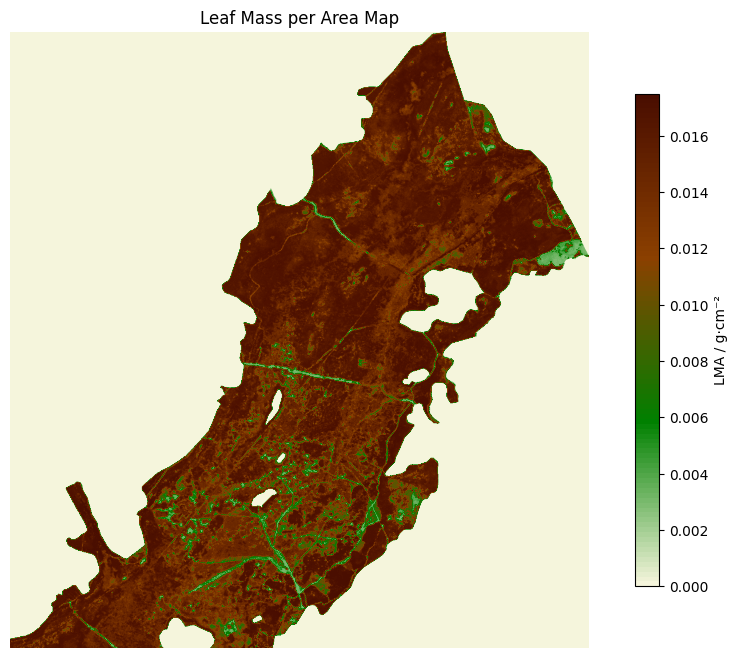

In [ ]:
import shapefile
from shapely.geometry import shape
import rasterio.features

sf = shapefile.Reader(f'{data_path}/Las_Tablas_north.shp')
geometries = [shape(shp) for shp in sf.shapes()]

# Rasterize vector features onto grid
shapes = [(geom, 1) for geom in geometries]
daimiel_raster = rasterio.features.rasterize(
    shapes=shapes,
    out_shape=lma_map.shape,
    transform=transform,
    fill=0,
    dtype=np.float32
)

# mask
lma_map_masked = lma_map * daimiel_raster

plt.figure(figsize=(12, 8))
img2 = plt.imshow(lma_map_masked, cmap=cmap)
                
plt.colorbar(img2, label='LMA / g·cm⁻²', shrink=0.8)
plt.title('Leaf Mass per Area Map')
plt.axis('off')

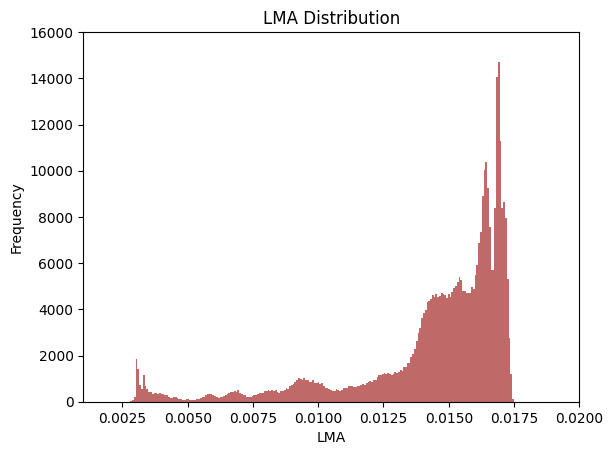

In [109]:
plt.hist(lma_map_masked.ravel(), bins=256, color='brown', alpha=0.7)
plt.title('LMA Distribution')
plt.xlabel('LMA')
plt.ylabel('Frequency')
plt.xlim(0.001, 0.02)
plt.ylim(0, 16000)
plt.show()

### Q7.9: 
Describe the pattern of the LMA distribution in 2, 3 sentences. Can you identify spatial trends across
the wetland?

**Answer:** The southern regions show lower values, associated with wetter, (maybe low-lying) areas (rivers are here clearly visible). In the northern regions we have higher LAM values, where the highest values are often grouped/clustered together. From the histogram (and image) we clearly see the higher LAM values dominating.

## Cross verification of the prediction

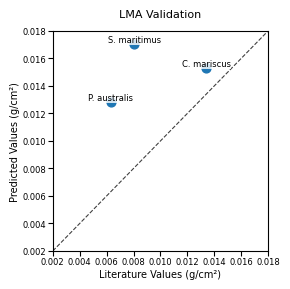

In [ ]:
from shapefile import Reader
from rasterio.features import geometry_mask

sf = Reader(f"{data_path}/species.shp")
literature = [0.01340483, 0.006321113, 0.00805153]
species_labels = ["C. mariscus", "P. australis", "S. maritimus"]

# mean lma for polygon
def get_zonal_mean(shape, lma_map, transform):
    geom = shape.__geo_interface__
    mask = geometry_mask([geom], lma_map.shape, transform, invert=True)
    return np.nanmean(lma_map[mask])

lma_values = []
for shape in sf.shapeRecords():
    if shape.shape.shapeType == 5: # polygon
        lma_values.append(get_zonal_mean(shape.shape, lma_map, transform))
    else:
        raise ValueError("Unsupported shape type")

plt.figure(figsize=(3, 3))
ax = plt.gca()

sc = ax.scatter(literature, lma_values, s=40, zorder=3, linewidth=1)

lims = [0.002, 0.018]
ax.plot(lims, lims, 'k--', alpha=0.75, linewidth=0.8) # f(x) = x

# annotations
for i, (lit, val) in enumerate(zip(literature, lma_values)):
    ax.text(lit, val, species_labels[i], 
            fontsize=6, ha='center', va='bottom',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=0.5))

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Literature Values (g/cm²)", labelpad=2, fontsize=7)
ax.set_ylabel("Predicted Values (g/cm²)", labelpad=2, fontsize=7)
ax.set_title("LMA Validation", fontsize=8, pad=10)

ax.tick_params(axis='both', which='major', labelsize=6, pad=1)

plt.tight_layout()
plt.show()

### Q7.10: 
Which species has thus the thickest leaves?

**Answer:** Cladium mariscus (sawtooth sedge) has the highest LMA, thus the thickest leaves.

### Q7.11: 
Read the paper by Darvishzadeh et al. (2011). They use an alternative inversion approach differing
from our statistical solution. How does this approach work?

**Answer:** They used the lookup table of 100,000 parameter combinations and observed HyMap spectra were compared to the LUT entries using RMSE. Then the mean of the top 10 best-matching combinations (that yielded the smallest RMSE) was calculated as solution.

Wavelengths poorly simulated by PROSAIL or affected by noise were discarded for a final subset of 107 bands, that showed better accuracy.

### Q7.12: 
Post your own question for the discussion in Moodle.

**My Question**

From Table 1, the measured LAI values ranged from 0.72 to 7.54, with a mean of 2.87, standard deviation of 1.59. 

The authors note (also visible in Fig3):

> "However, as only four out of forty-one samples had LAI > 5, the statement remains vague."

This suggests a skewed distribution. PLSR assumes predictor/response variables are roughly normally distributed for optimal performance.

Could transformations (e.g., log, square root, or Box-Cox) have improved PLSR performance by trying to normalize the distribution? 
Additionally, is this skewness also an issue for the RTF, because they used uniform sampling for LAI in the LUT?
